In [50]:
# =============================================================================
# Adding Essential Dependencies
# =============================================================================

import os
import scipy.io as sio
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import _supervised
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score

In [51]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# =============================================================================
# Clustering Accuracy (CA)
# =============================================================================
def clustering_accuracy(labels_true, labels_pred):
    labels_true, labels_pred = _supervised.check_clusterings(labels_true, labels_pred)
    value = _supervised.contingency_matrix(labels_true, labels_pred)
    [r, c] = linear_sum_assignment(-value)
    return value[r, c].sum() / len(labels_true)
# =============================================================================

# =============================================================================
# Adjust rand index (ARI)
# =============================================================================
def ARI(labels_true, labels_pred):
    ari = adjusted_rand_score(labels_true, labels_pred)
    return ari
# =============================================================================




# =============================================================================
# Normalized mutual information (NMI)
# =============================================================================
def NMI(labels_true, labels_pred):
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    return nmi
# =============================================================================

In [52]:
# =============================================================================
# AE architecture
# =============================================================================

class Lin(nn.Module):
    def __init__(self, in_feature, out_features):
        super(Lin, self).__init__()

        self.lin = nn.Sequential(
            nn.Linear(in_feature,out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU(),
        )

    def forward(self, x):

        x = self.lin(x)
        return x
class AE(nn.Module):
    def __init__(self, num_features=2):
        super(AE, self).__init__()

        self.line1 = Lin(2,32)
        self.line2 = Lin(32,64)
        self.line3 = Lin(64,128)
        self.line4 = Lin(128,256)
        self.line5 = Lin(256,512)
        self.line6 = Lin(512,1024)
        self.line7 = Lin(1024,num_features)


        self.deline1 = Lin(num_features,1024)
        self.deline2 = Lin(1024, 512)
        self.deline3 = Lin(512,256)
        self.deline4 = Lin(256,128)
        self.deline5 = Lin(128,64)
        self.deline6 = Lin(64,32)
        self.deline7 = Lin(32,2)






    def forward(self, x):
        x = self.line1(x)
        x = self.line2(x)
        x = self.line3(x)
        x = self.line4(x)
        x = self.line5(x)
        x = self.line6(x)
        x = self.line7(x)

        code = x


        x = self.deline1(x)
        x = self.deline2(x)
        x = self.deline3(x)
        x = self.deline4(x)
        x = self.deline5(x)
        x = self.deline6(x)
        x = self.deline7(x)



        return x.view(-1,1), code

In [53]:
# =============================================================================
# Reading the input data and its corresponding GT 
# =============================================================================
country = "India_570384"
X_in = sio.loadmat("./"+str(country)+"_S1_HAND.mat")["data"]
Y = sio.loadmat("./"+str(country)+"_S1_HAND.mat")["GT"]
[m,n,l] = X_in.shape

print("The dimension of the input image is:"+str(X_in.shape))

print("The dimension of the GT is:"+str(Y.shape))







The dimension of the input image is:(512, 512, 2)
The dimension of the GT is:(512, 512)


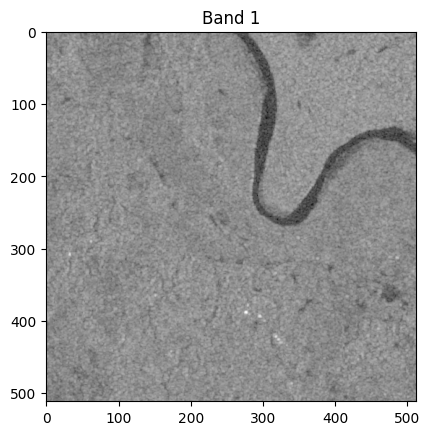

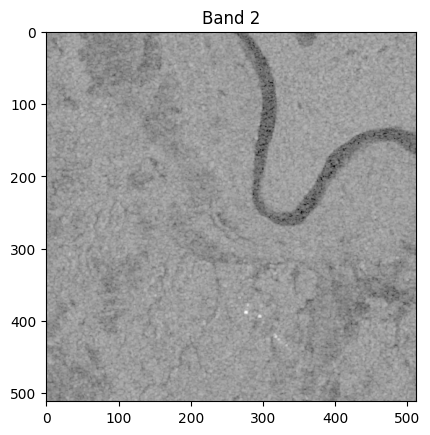

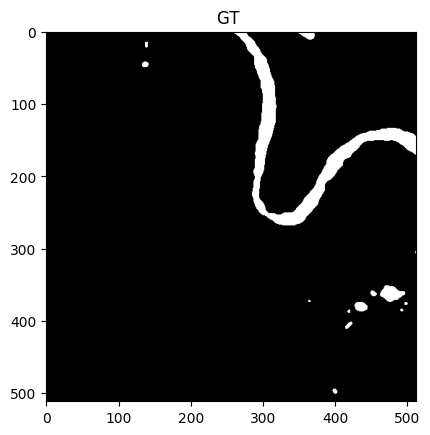

In [54]:
# =============================================================================
# Depicting the image features and GT
# =============================================================================
for i in range(X_in.shape[2]):
    plt.imshow(X_in[:,:,i], cmap="gray")
    plt.title("Band "+str(i+1))
    plt.show()
plt.imshow(Y, cmap="gray")
plt.title("GT ")
plt.show()

In [55]:
# =============================================================================
# Reshaping the input image to feed into the AE
# =============================================================================


X_in = np.reshape(X_in,(X_in.shape[0]*X_in.shape[1],X_in.shape[2]))
X_in = X_in/255
X_in = np.float32(X_in)
tmpt = torch.from_numpy(X_in)



y = np.reshape(Y,(Y.shape[0]*Y.shape[1],-1))
y_test = y.reshape((m*n))
y_test = y_test.astype(int) + 1
print("The number of classes in the scene is:"+str(np.unique(y_test)))

The number of classes in the scene is:[1 2]


In [56]:
# =============================================================================
# Cehcking the availibilty of the GPU
# =============================================================================


if torch.cuda.is_available()==True:
    print("Cuda is avaialbe on the device")
    print(f"GPU is: ",torch.cuda.get_device_name(0))
else:
    print("Cuda is not avaialbe on the device")

if torch.cuda.device_count() >= 1:
    model = AE()
    model.cuda()
else:
    model = AE()

# =============================================================================
# Setting up the hyperparameters for the AE
# =============================================================================
    

model.apply(weights_init)
LR = 0.01
Iter = 200
thr = 100
optimizer_model = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = nn.MSELoss()

losses = []
print(model)
print(count_parameters(model))

Cuda is avaialbe on the device
GPU is:  NVIDIA RTX A2000 8GB Laptop GPU
AE(
  (line1): Lin(
    (lin): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (line2): Lin(
    (lin): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (line3): Lin(
    (lin): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (line4): Lin(
    (lin): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [57]:
# =============================================================================
# Training AE in an unsupervised fashion
# =============================================================================


for i in tqdm(range(Iter)):
      model.train()
      rec_out, code = model(tmpt.cuda())
      loss = loss_func(rec_out, tmpt.view(-1,1).cuda())
      losses.append(loss.cpu().item())
      optimizer_model.zero_grad()
      loss.backward()
      optimizer_model.step()
      print('Iteration: ', i+1, '| Total loss: %.4f' % loss.data.cpu().numpy())
      if loss.data.cpu().numpy() < thr:
          torch.save(model.state_dict(), './net_params_model.pkl')
          thr = loss.data.cpu().numpy()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:03<12:54,  3.89s/it]

Iteration:  0 | Total loss: 0.3042


  1%|          | 2/200 [00:07<12:17,  3.72s/it]

Iteration:  1 | Total loss: 0.1112


  2%|▏         | 3/200 [00:11<12:02,  3.67s/it]

Iteration:  2 | Total loss: 0.0447


  2%|▏         | 4/200 [00:14<11:52,  3.63s/it]

Iteration:  3 | Total loss: 0.0309


  2%|▎         | 5/200 [00:18<11:45,  3.62s/it]

Iteration:  4 | Total loss: 0.0262


  3%|▎         | 6/200 [00:21<11:40,  3.61s/it]

Iteration:  5 | Total loss: 0.0214


  4%|▎         | 7/200 [00:25<11:36,  3.61s/it]

Iteration:  6 | Total loss: 0.0173


  4%|▍         | 8/200 [00:29<11:31,  3.60s/it]

Iteration:  7 | Total loss: 0.0139


  4%|▍         | 9/200 [00:32<11:28,  3.60s/it]

Iteration:  8 | Total loss: 0.0101


  5%|▌         | 10/200 [00:36<11:24,  3.60s/it]

Iteration:  9 | Total loss: 0.0066


  6%|▌         | 11/200 [00:39<11:21,  3.61s/it]

Iteration:  10 | Total loss: 0.0044


  6%|▌         | 12/200 [00:43<11:17,  3.60s/it]

Iteration:  11 | Total loss: 0.0031


  6%|▋         | 13/200 [00:47<11:13,  3.60s/it]

Iteration:  12 | Total loss: 0.0027


  7%|▋         | 14/200 [00:50<11:09,  3.60s/it]

Iteration:  13 | Total loss: 0.0026


  8%|▊         | 15/200 [00:54<11:05,  3.60s/it]

Iteration:  14 | Total loss: 0.0025


  8%|▊         | 16/200 [00:57<11:01,  3.60s/it]

Iteration:  15 | Total loss: 0.0025


  8%|▊         | 17/200 [01:01<10:59,  3.60s/it]

Iteration:  16 | Total loss: 0.0025


  9%|▉         | 18/200 [01:05<10:56,  3.61s/it]

Iteration:  17 | Total loss: 0.0025


 10%|▉         | 19/200 [01:08<10:52,  3.61s/it]

Iteration:  18 | Total loss: 0.0025


 10%|█         | 20/200 [01:12<10:49,  3.61s/it]

Iteration:  19 | Total loss: 0.0025


 10%|█         | 21/200 [01:15<10:46,  3.61s/it]

Iteration:  20 | Total loss: 0.0025


 11%|█         | 22/200 [01:19<10:42,  3.61s/it]

Iteration:  21 | Total loss: 0.0025


 12%|█▏        | 23/200 [01:23<10:38,  3.61s/it]

Iteration:  22 | Total loss: 0.0025


 12%|█▏        | 24/200 [01:26<10:35,  3.61s/it]

Iteration:  23 | Total loss: 0.0025


 12%|█▎        | 25/200 [01:30<10:31,  3.61s/it]

Iteration:  24 | Total loss: 0.0025


 13%|█▎        | 26/200 [01:33<10:28,  3.61s/it]

Iteration:  25 | Total loss: 0.0025


 14%|█▎        | 27/200 [01:37<10:23,  3.61s/it]

Iteration:  26 | Total loss: 0.0025


 14%|█▍        | 28/200 [01:41<10:20,  3.61s/it]

Iteration:  27 | Total loss: 0.0025


 14%|█▍        | 29/200 [01:44<10:16,  3.60s/it]

Iteration:  28 | Total loss: 0.0025


 15%|█▌        | 30/200 [01:48<10:12,  3.60s/it]

Iteration:  29 | Total loss: 0.0025


 16%|█▌        | 31/200 [01:51<10:08,  3.60s/it]

Iteration:  30 | Total loss: 0.0025


 16%|█▌        | 32/200 [01:55<10:04,  3.60s/it]

Iteration:  31 | Total loss: 0.0025


 16%|█▋        | 33/200 [01:59<10:01,  3.60s/it]

Iteration:  32 | Total loss: 0.0025


 17%|█▋        | 34/200 [02:02<09:57,  3.60s/it]

Iteration:  33 | Total loss: 0.0025


 18%|█▊        | 35/200 [02:06<09:53,  3.60s/it]

Iteration:  34 | Total loss: 0.0025


 18%|█▊        | 36/200 [02:09<09:49,  3.60s/it]

Iteration:  35 | Total loss: 0.0025


 18%|█▊        | 37/200 [02:13<09:46,  3.60s/it]

Iteration:  36 | Total loss: 0.0025


 19%|█▉        | 38/200 [02:17<09:42,  3.60s/it]

Iteration:  37 | Total loss: 0.0025


 20%|█▉        | 39/200 [02:20<09:39,  3.60s/it]

Iteration:  38 | Total loss: 0.0025


 20%|██        | 40/200 [02:24<09:35,  3.60s/it]

Iteration:  39 | Total loss: 0.0025


 20%|██        | 41/200 [02:27<09:31,  3.59s/it]

Iteration:  40 | Total loss: 0.0025


 21%|██        | 42/200 [02:31<09:27,  3.59s/it]

Iteration:  41 | Total loss: 0.0025


 22%|██▏       | 43/200 [02:35<09:24,  3.59s/it]

Iteration:  42 | Total loss: 0.0025


 22%|██▏       | 44/200 [02:38<09:20,  3.59s/it]

Iteration:  43 | Total loss: 0.0025


 22%|██▎       | 45/200 [02:42<09:16,  3.59s/it]

Iteration:  44 | Total loss: 0.0024


 23%|██▎       | 46/200 [02:45<09:13,  3.59s/it]

Iteration:  45 | Total loss: 0.0024


 24%|██▎       | 47/200 [02:49<09:09,  3.59s/it]

Iteration:  46 | Total loss: 0.0024


 24%|██▍       | 48/200 [02:53<09:05,  3.59s/it]

Iteration:  47 | Total loss: 0.0024


 24%|██▍       | 49/200 [02:56<09:02,  3.59s/it]

Iteration:  48 | Total loss: 0.0024


 25%|██▌       | 50/200 [03:00<08:58,  3.59s/it]

Iteration:  49 | Total loss: 0.0024


 26%|██▌       | 51/200 [03:03<08:54,  3.59s/it]

Iteration:  50 | Total loss: 0.0024


 26%|██▌       | 52/200 [03:07<08:51,  3.59s/it]

Iteration:  51 | Total loss: 0.0024


 26%|██▋       | 53/200 [03:11<08:48,  3.59s/it]

Iteration:  52 | Total loss: 0.0024


 27%|██▋       | 54/200 [03:14<08:44,  3.59s/it]

Iteration:  53 | Total loss: 0.0024


 28%|██▊       | 55/200 [03:18<08:41,  3.59s/it]

Iteration:  54 | Total loss: 0.0024


 28%|██▊       | 56/200 [03:21<08:37,  3.59s/it]

Iteration:  55 | Total loss: 0.0024


 28%|██▊       | 57/200 [03:25<08:33,  3.59s/it]

Iteration:  56 | Total loss: 0.0024


 29%|██▉       | 58/200 [03:28<08:29,  3.59s/it]

Iteration:  57 | Total loss: 0.0024


 30%|██▉       | 59/200 [03:32<08:25,  3.59s/it]

Iteration:  58 | Total loss: 0.0024


 30%|███       | 60/200 [03:36<08:21,  3.58s/it]

Iteration:  59 | Total loss: 0.0024


 30%|███       | 61/200 [03:39<08:18,  3.59s/it]

Iteration:  60 | Total loss: 0.0024


 31%|███       | 62/200 [03:43<08:15,  3.59s/it]

Iteration:  61 | Total loss: 0.0024


 32%|███▏      | 63/200 [03:46<08:11,  3.59s/it]

Iteration:  62 | Total loss: 0.0024


 32%|███▏      | 64/200 [03:50<08:07,  3.58s/it]

Iteration:  63 | Total loss: 0.0024


 32%|███▎      | 65/200 [03:54<08:03,  3.58s/it]

Iteration:  64 | Total loss: 0.0024


 33%|███▎      | 66/200 [03:57<08:00,  3.59s/it]

Iteration:  65 | Total loss: 0.0024


 34%|███▎      | 67/200 [04:01<07:56,  3.59s/it]

Iteration:  66 | Total loss: 0.0024


 34%|███▍      | 68/200 [04:04<07:53,  3.59s/it]

Iteration:  67 | Total loss: 0.0024


 34%|███▍      | 69/200 [04:08<07:50,  3.59s/it]

Iteration:  68 | Total loss: 0.0024


 35%|███▌      | 70/200 [04:12<07:46,  3.59s/it]

Iteration:  69 | Total loss: 0.0024


 36%|███▌      | 71/200 [04:15<07:43,  3.59s/it]

Iteration:  70 | Total loss: 0.0024


 36%|███▌      | 72/200 [04:19<07:39,  3.59s/it]

Iteration:  71 | Total loss: 0.0024


 36%|███▋      | 73/200 [04:22<07:36,  3.59s/it]

Iteration:  72 | Total loss: 0.0024


 37%|███▋      | 74/200 [04:26<07:32,  3.59s/it]

Iteration:  73 | Total loss: 0.0024


 38%|███▊      | 75/200 [04:29<07:29,  3.59s/it]

Iteration:  74 | Total loss: 0.0024


 38%|███▊      | 76/200 [04:33<07:25,  3.59s/it]

Iteration:  75 | Total loss: 0.0024


 38%|███▊      | 77/200 [04:37<07:21,  3.59s/it]

Iteration:  76 | Total loss: 0.0024


 39%|███▉      | 78/200 [04:40<07:18,  3.59s/it]

Iteration:  77 | Total loss: 0.0024


 40%|███▉      | 79/200 [04:44<07:14,  3.59s/it]

Iteration:  78 | Total loss: 0.0024


 40%|████      | 80/200 [04:47<07:10,  3.59s/it]

Iteration:  79 | Total loss: 0.0024


 40%|████      | 81/200 [04:51<07:07,  3.59s/it]

Iteration:  80 | Total loss: 0.0024


 41%|████      | 82/200 [04:55<07:04,  3.60s/it]

Iteration:  81 | Total loss: 0.0024


 42%|████▏     | 83/200 [04:58<07:00,  3.59s/it]

Iteration:  82 | Total loss: 0.0024


 42%|████▏     | 84/200 [05:02<06:56,  3.59s/it]

Iteration:  83 | Total loss: 0.0024


 42%|████▎     | 85/200 [05:05<06:53,  3.59s/it]

Iteration:  84 | Total loss: 0.0024


 43%|████▎     | 86/200 [05:09<06:49,  3.60s/it]

Iteration:  85 | Total loss: 0.0024


 44%|████▎     | 87/200 [05:13<06:46,  3.60s/it]

Iteration:  86 | Total loss: 0.0024


 44%|████▍     | 88/200 [05:16<06:42,  3.59s/it]

Iteration:  87 | Total loss: 0.0024


 44%|████▍     | 89/200 [05:20<06:39,  3.60s/it]

Iteration:  88 | Total loss: 0.0024


 45%|████▌     | 90/200 [05:23<06:35,  3.59s/it]

Iteration:  89 | Total loss: 0.0024


 46%|████▌     | 91/200 [05:27<06:31,  3.59s/it]

Iteration:  90 | Total loss: 0.0024


 46%|████▌     | 92/200 [05:31<06:27,  3.59s/it]

Iteration:  91 | Total loss: 0.0024


 46%|████▋     | 93/200 [05:34<06:24,  3.60s/it]

Iteration:  92 | Total loss: 0.0024


 47%|████▋     | 94/200 [05:38<06:20,  3.59s/it]

Iteration:  93 | Total loss: 0.0024


 48%|████▊     | 95/200 [05:41<06:17,  3.60s/it]

Iteration:  94 | Total loss: 0.0024


 48%|████▊     | 96/200 [05:45<06:14,  3.60s/it]

Iteration:  95 | Total loss: 0.0024


 48%|████▊     | 97/200 [05:49<06:10,  3.60s/it]

Iteration:  96 | Total loss: 0.0024


 49%|████▉     | 98/200 [05:52<06:08,  3.61s/it]

Iteration:  97 | Total loss: 0.0024


 50%|████▉     | 99/200 [05:56<06:04,  3.61s/it]

Iteration:  98 | Total loss: 0.0024


 50%|█████     | 100/200 [05:59<06:00,  3.61s/it]

Iteration:  99 | Total loss: 0.0024


 50%|█████     | 101/200 [06:03<05:57,  3.61s/it]

Iteration:  100 | Total loss: 0.0024


 51%|█████     | 102/200 [06:07<05:53,  3.60s/it]

Iteration:  101 | Total loss: 0.0024


 52%|█████▏    | 103/200 [06:10<05:49,  3.60s/it]

Iteration:  102 | Total loss: 0.0024


 52%|█████▏    | 104/200 [06:14<05:47,  3.61s/it]

Iteration:  103 | Total loss: 0.0024


 52%|█████▎    | 105/200 [06:17<05:43,  3.61s/it]

Iteration:  104 | Total loss: 0.0024


 53%|█████▎    | 106/200 [06:21<05:39,  3.61s/it]

Iteration:  105 | Total loss: 0.0024


 54%|█████▎    | 107/200 [06:25<05:35,  3.61s/it]

Iteration:  106 | Total loss: 0.0024


 54%|█████▍    | 108/200 [06:28<05:32,  3.61s/it]

Iteration:  107 | Total loss: 0.0024


 55%|█████▍    | 109/200 [06:32<05:28,  3.61s/it]

Iteration:  108 | Total loss: 0.0024


 55%|█████▌    | 110/200 [06:36<05:24,  3.61s/it]

Iteration:  109 | Total loss: 0.0024


 56%|█████▌    | 111/200 [06:39<05:21,  3.61s/it]

Iteration:  110 | Total loss: 0.0024


 56%|█████▌    | 112/200 [06:43<05:17,  3.61s/it]

Iteration:  111 | Total loss: 0.0024


 56%|█████▋    | 113/200 [06:46<05:13,  3.61s/it]

Iteration:  112 | Total loss: 0.0024


 57%|█████▋    | 114/200 [06:50<05:10,  3.61s/it]

Iteration:  113 | Total loss: 0.0024


 57%|█████▊    | 115/200 [06:54<05:06,  3.60s/it]

Iteration:  114 | Total loss: 0.0024


 58%|█████▊    | 116/200 [06:57<05:02,  3.60s/it]

Iteration:  115 | Total loss: 0.0024


 58%|█████▊    | 117/200 [07:01<04:58,  3.60s/it]

Iteration:  116 | Total loss: 0.0024


 59%|█████▉    | 118/200 [07:04<04:55,  3.60s/it]

Iteration:  117 | Total loss: 0.0024


 60%|█████▉    | 119/200 [07:08<04:51,  3.60s/it]

Iteration:  118 | Total loss: 0.0024


 60%|██████    | 120/200 [07:12<04:48,  3.61s/it]

Iteration:  119 | Total loss: 0.0024


 60%|██████    | 121/200 [07:15<04:44,  3.60s/it]

Iteration:  120 | Total loss: 0.0024


 61%|██████    | 122/200 [07:19<04:40,  3.60s/it]

Iteration:  121 | Total loss: 0.0024


 62%|██████▏   | 123/200 [07:22<04:37,  3.60s/it]

Iteration:  122 | Total loss: 0.0024


 62%|██████▏   | 124/200 [07:26<04:33,  3.60s/it]

Iteration:  123 | Total loss: 0.0024


 62%|██████▎   | 125/200 [07:30<04:29,  3.60s/it]

Iteration:  124 | Total loss: 0.0024


 63%|██████▎   | 126/200 [07:33<04:26,  3.60s/it]

Iteration:  125 | Total loss: 0.0024


 64%|██████▎   | 127/200 [07:37<04:23,  3.61s/it]

Iteration:  126 | Total loss: 0.0024


 64%|██████▍   | 128/200 [07:40<04:19,  3.60s/it]

Iteration:  127 | Total loss: 0.0024


 64%|██████▍   | 129/200 [07:44<04:15,  3.60s/it]

Iteration:  128 | Total loss: 0.0024


 65%|██████▌   | 130/200 [07:48<04:12,  3.60s/it]

Iteration:  129 | Total loss: 0.0024


 66%|██████▌   | 131/200 [07:51<04:08,  3.60s/it]

Iteration:  130 | Total loss: 0.0024


 66%|██████▌   | 132/200 [07:55<04:04,  3.60s/it]

Iteration:  131 | Total loss: 0.0024


 66%|██████▋   | 133/200 [07:58<04:01,  3.60s/it]

Iteration:  132 | Total loss: 0.0024


 67%|██████▋   | 134/200 [08:02<03:57,  3.61s/it]

Iteration:  133 | Total loss: 0.0024


 68%|██████▊   | 135/200 [08:06<03:54,  3.61s/it]

Iteration:  134 | Total loss: 0.0024


 68%|██████▊   | 136/200 [08:09<03:50,  3.61s/it]

Iteration:  135 | Total loss: 0.0024


 68%|██████▊   | 137/200 [08:13<03:47,  3.61s/it]

Iteration:  136 | Total loss: 0.0024


 69%|██████▉   | 138/200 [08:16<03:43,  3.61s/it]

Iteration:  137 | Total loss: 0.0024


 70%|██████▉   | 139/200 [08:20<03:40,  3.61s/it]

Iteration:  138 | Total loss: 0.0024


 70%|███████   | 140/200 [08:24<03:36,  3.61s/it]

Iteration:  139 | Total loss: 0.0024


 70%|███████   | 141/200 [08:27<03:32,  3.61s/it]

Iteration:  140 | Total loss: 0.0024


 71%|███████   | 142/200 [08:31<03:29,  3.61s/it]

Iteration:  141 | Total loss: 0.0024


 72%|███████▏  | 143/200 [08:34<03:25,  3.61s/it]

Iteration:  142 | Total loss: 0.0024


 72%|███████▏  | 144/200 [08:38<03:22,  3.61s/it]

Iteration:  143 | Total loss: 0.0024


 72%|███████▎  | 145/200 [08:42<03:18,  3.61s/it]

Iteration:  144 | Total loss: 0.0024


 73%|███████▎  | 146/200 [08:45<03:14,  3.60s/it]

Iteration:  145 | Total loss: 0.0024


 74%|███████▎  | 147/200 [08:49<03:10,  3.60s/it]

Iteration:  146 | Total loss: 0.0024


 74%|███████▍  | 148/200 [08:52<03:07,  3.60s/it]

Iteration:  147 | Total loss: 0.0024


 74%|███████▍  | 149/200 [08:56<03:03,  3.60s/it]

Iteration:  148 | Total loss: 0.0024


 75%|███████▌  | 150/200 [09:00<03:00,  3.60s/it]

Iteration:  149 | Total loss: 0.0024


 76%|███████▌  | 151/200 [09:03<02:56,  3.60s/it]

Iteration:  150 | Total loss: 0.0024


 76%|███████▌  | 152/200 [09:07<02:52,  3.60s/it]

Iteration:  151 | Total loss: 0.0024


 76%|███████▋  | 153/200 [09:10<02:49,  3.60s/it]

Iteration:  152 | Total loss: 0.0024


 77%|███████▋  | 154/200 [09:14<02:45,  3.60s/it]

Iteration:  153 | Total loss: 0.0024


 78%|███████▊  | 155/200 [09:18<02:42,  3.60s/it]

Iteration:  154 | Total loss: 0.0024


 78%|███████▊  | 156/200 [09:21<02:38,  3.60s/it]

Iteration:  155 | Total loss: 0.0024


 78%|███████▊  | 157/200 [09:25<02:34,  3.60s/it]

Iteration:  156 | Total loss: 0.0024


 79%|███████▉  | 158/200 [09:28<02:31,  3.60s/it]

Iteration:  157 | Total loss: 0.0024


 80%|███████▉  | 159/200 [09:32<02:27,  3.60s/it]

Iteration:  158 | Total loss: 0.0024


 80%|████████  | 160/200 [09:36<02:24,  3.60s/it]

Iteration:  159 | Total loss: 0.0024


 80%|████████  | 161/200 [09:39<02:20,  3.61s/it]

Iteration:  160 | Total loss: 0.0024


 81%|████████  | 162/200 [09:43<02:17,  3.61s/it]

Iteration:  161 | Total loss: 0.0024


 82%|████████▏ | 163/200 [09:47<02:13,  3.61s/it]

Iteration:  162 | Total loss: 0.0024


 82%|████████▏ | 164/200 [09:50<02:09,  3.61s/it]

Iteration:  163 | Total loss: 0.0024


 82%|████████▎ | 165/200 [09:54<02:06,  3.61s/it]

Iteration:  164 | Total loss: 0.0024


 83%|████████▎ | 166/200 [09:57<02:02,  3.60s/it]

Iteration:  165 | Total loss: 0.0024


 84%|████████▎ | 167/200 [10:01<01:58,  3.60s/it]

Iteration:  166 | Total loss: 0.0024


 84%|████████▍ | 168/200 [10:05<01:55,  3.60s/it]

Iteration:  167 | Total loss: 0.0024


 84%|████████▍ | 169/200 [10:08<01:51,  3.61s/it]

Iteration:  168 | Total loss: 0.0024


 85%|████████▌ | 170/200 [10:12<01:48,  3.60s/it]

Iteration:  169 | Total loss: 0.0024


 86%|████████▌ | 171/200 [10:15<01:44,  3.61s/it]

Iteration:  170 | Total loss: 0.0024


 86%|████████▌ | 172/200 [10:19<01:41,  3.61s/it]

Iteration:  171 | Total loss: 0.0024


 86%|████████▋ | 173/200 [10:23<01:37,  3.61s/it]

Iteration:  172 | Total loss: 0.0024


 87%|████████▋ | 174/200 [10:26<01:33,  3.60s/it]

Iteration:  173 | Total loss: 0.0024


 88%|████████▊ | 175/200 [10:30<01:29,  3.60s/it]

Iteration:  174 | Total loss: 0.0024


 88%|████████▊ | 176/200 [10:33<01:26,  3.60s/it]

Iteration:  175 | Total loss: 0.0024


 88%|████████▊ | 177/200 [10:37<01:22,  3.60s/it]

Iteration:  176 | Total loss: 0.0024


 89%|████████▉ | 178/200 [10:41<01:19,  3.60s/it]

Iteration:  177 | Total loss: 0.0024


 90%|████████▉ | 179/200 [10:44<01:15,  3.60s/it]

Iteration:  178 | Total loss: 0.0024


 90%|█████████ | 180/200 [10:48<01:11,  3.60s/it]

Iteration:  179 | Total loss: 0.0024


 90%|█████████ | 181/200 [10:51<01:08,  3.60s/it]

Iteration:  180 | Total loss: 0.0024


 91%|█████████ | 182/200 [10:55<01:04,  3.60s/it]

Iteration:  181 | Total loss: 0.0024


 92%|█████████▏| 183/200 [10:59<01:01,  3.60s/it]

Iteration:  182 | Total loss: 0.0024


 92%|█████████▏| 184/200 [11:02<00:57,  3.60s/it]

Iteration:  183 | Total loss: 0.0024


 92%|█████████▎| 185/200 [11:06<00:54,  3.60s/it]

Iteration:  184 | Total loss: 0.0024


 93%|█████████▎| 186/200 [11:09<00:50,  3.60s/it]

Iteration:  185 | Total loss: 0.0024


 94%|█████████▎| 187/200 [11:13<00:46,  3.60s/it]

Iteration:  186 | Total loss: 0.0024


 94%|█████████▍| 188/200 [11:17<00:43,  3.60s/it]

Iteration:  187 | Total loss: 0.0024


 94%|█████████▍| 189/200 [11:20<00:39,  3.60s/it]

Iteration:  188 | Total loss: 0.0024


 95%|█████████▌| 190/200 [11:24<00:36,  3.60s/it]

Iteration:  189 | Total loss: 0.0024


 96%|█████████▌| 191/200 [11:27<00:32,  3.61s/it]

Iteration:  190 | Total loss: 0.0024


 96%|█████████▌| 192/200 [11:31<00:28,  3.60s/it]

Iteration:  191 | Total loss: 0.0024


 96%|█████████▋| 193/200 [11:35<00:25,  3.60s/it]

Iteration:  192 | Total loss: 0.0024


 97%|█████████▋| 194/200 [11:38<00:21,  3.60s/it]

Iteration:  193 | Total loss: 0.0024


 98%|█████████▊| 195/200 [11:42<00:17,  3.60s/it]

Iteration:  194 | Total loss: 0.0024


 98%|█████████▊| 196/200 [11:45<00:14,  3.61s/it]

Iteration:  195 | Total loss: 0.0024


 98%|█████████▊| 197/200 [11:49<00:10,  3.61s/it]

Iteration:  196 | Total loss: 0.0024


 99%|█████████▉| 198/200 [11:53<00:07,  3.60s/it]

Iteration:  197 | Total loss: 0.0024


100%|█████████▉| 199/200 [11:56<00:03,  3.60s/it]

Iteration:  198 | Total loss: 0.0024


100%|██████████| 200/200 [12:00<00:00,  3.60s/it]

Iteration:  199 | Total loss: 0.0024


In [58]:
# =============================================================================
# Loading the AE with the optimal parameters identified during the training process
# =============================================================================


model = AE().cuda()
model_dict = model.state_dict()
pretrained_dict = torch.load('./net_params_model.pkl')
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)



x = model.line1(tmpt.cuda())
x = model.line2(x)
x = model.line3(x)
x = model.line4(x)
x = model.line5(x)
x = model.line6(x)
x = model.line7(x)

x_ae = x.data.cpu().numpy()



# =============================================================================
# Applying PCA as an FE technique 
# =============================================================================


pca = PCA(n_components=2)
pc = pca.fit_transform(X_in)




x = x_ae.transpose(1,0)
pc_t = pc.transpose(1,0)

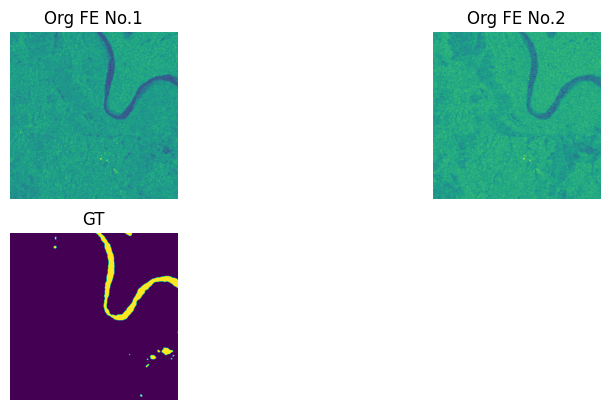

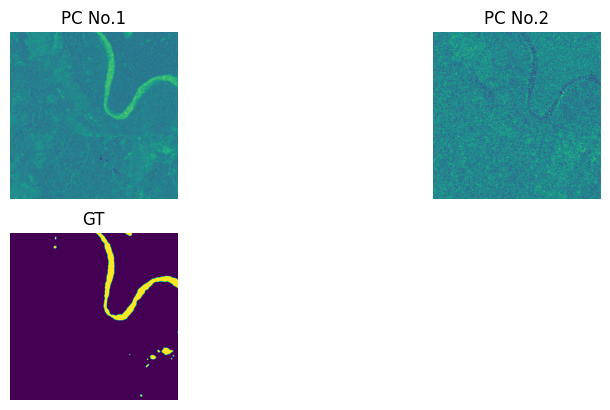

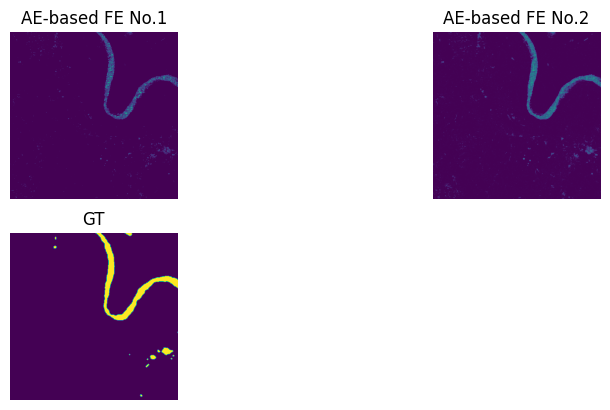

In [59]:
# =============================================================================
# Displaying the extracted features 
# =============================================================================


fig = plt.figure(figsize= (10, 10))
x_org = X_in.transpose(1,0)
for num, img in enumerate(x_org):
    ax = fig.add_subplot(x_org.shape[0]+2, 2, num+1)
    plt.title(label="Org FE No."+str(num+1))
    ax.axis('off')
    ax.imshow(img.reshape((m,n)))


ax = fig.add_subplot(x_org.shape[0]+2, 2, num+2)
plt.title(label="GT")
ax.axis('off')
ax.imshow(y_test.reshape((m,n)))

fig = plt.figure(figsize= (10, 10))
for num, img in enumerate(pc_t):
    ax = fig.add_subplot(pc_t.shape[0]+2, 2, num+1)
    plt.title(label="PC No."+str(num+1))
    ax.axis('off')
    ax.imshow(img.reshape((m,n)))

ax = fig.add_subplot(pc_t.shape[0]+2, 2, num+2)
plt.title(label="GT")
ax.axis('off')
ax.imshow(y_test.reshape((m,n)))


fig = plt.figure(figsize= (10, 10))
for num, img in enumerate(x):
    ax = fig.add_subplot(x.shape[0]+2, 2, num+1)
    plt.title(label="AE-based FE No."+str(num+1))
    ax.axis('off')
    ax.imshow(img.reshape((m,n)))

ax = fig.add_subplot(x.shape[0]+2, 2, num+2)
plt.title(label="GT")
ax.axis('off')
ax.imshow(y_test.reshape((m,n)))

[1 2]
[1 2]
[1 2]
CA_org:0.8566398620605469	CA_PCA:0.8497695922851562	CA_AE:0.9889411926269531
NMI_org:0.21098352761240988	NMI_PCA:0.20299922238850973	NMI_AE:0.6792730839702307
ARI_org:0.243289956293949	ARI_PCA:0.23108901873167886	ARI_AE:0.8196179995907212


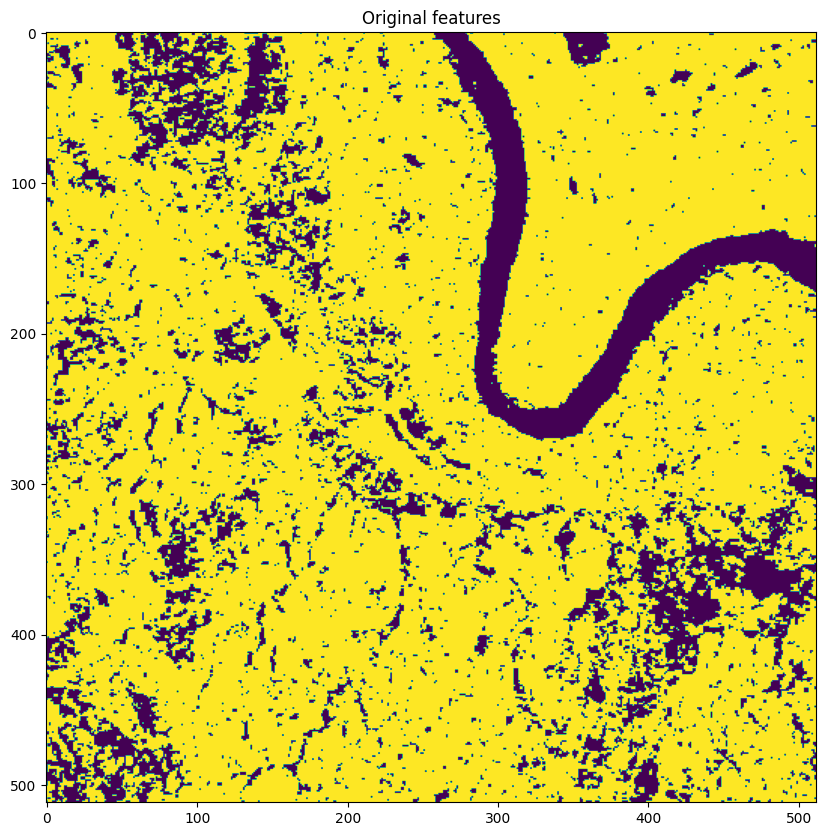

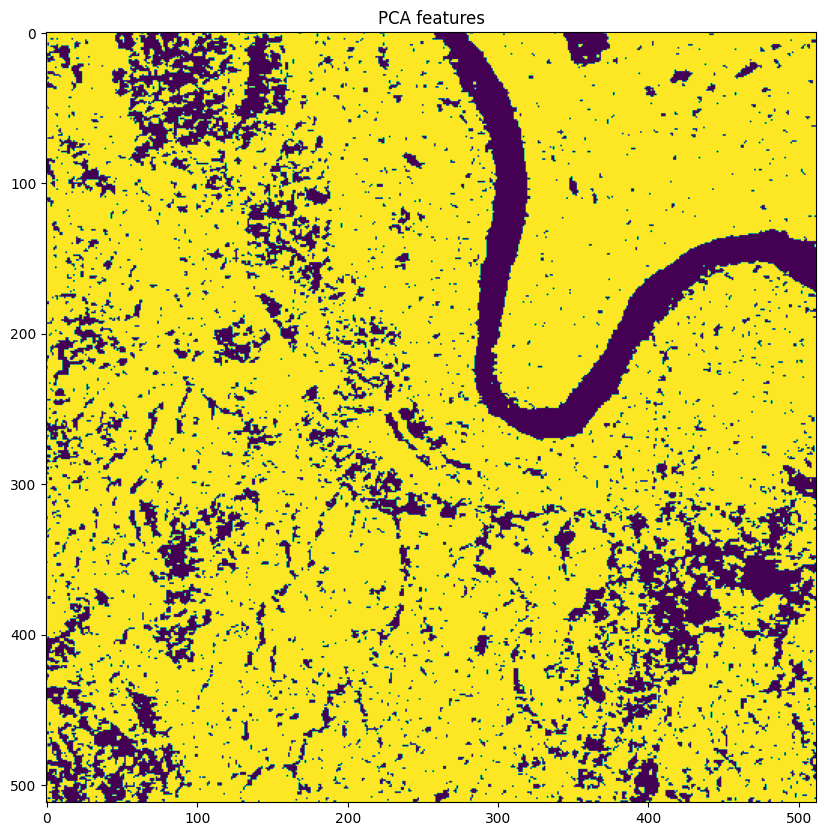

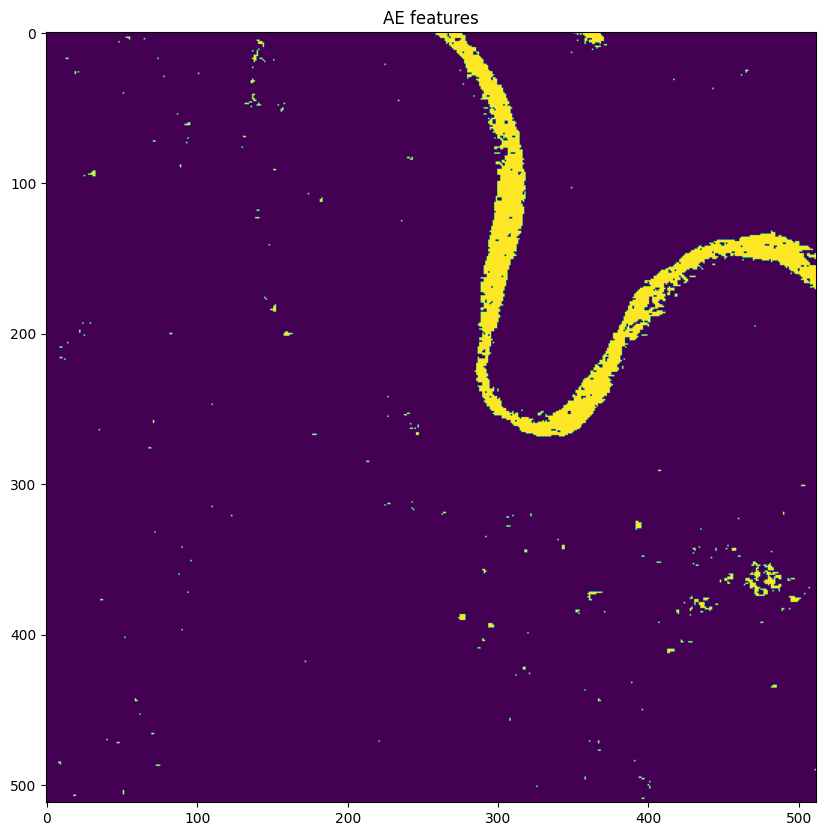

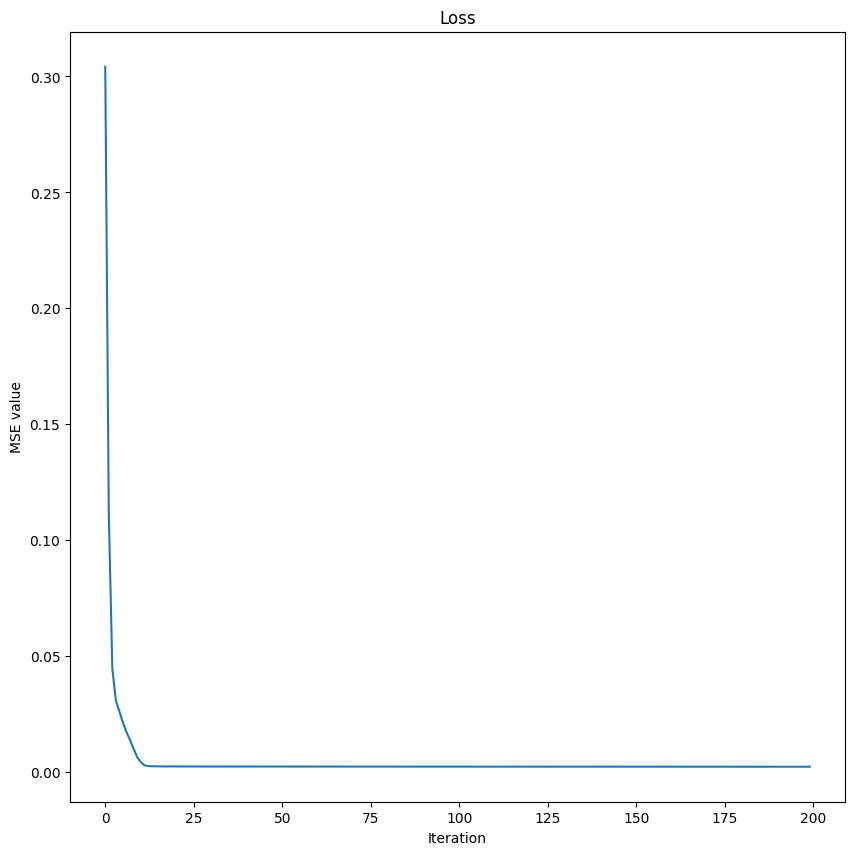

In [60]:
# =============================================================================
# Clustering step 
# =============================================================================

kmeans = KMeans(n_clusters=2)
km_org = kmeans.fit_predict(X_in)
# kmap_org = km_org.labels_
kmap_org = km_org + 1
print(np.unique(kmap_org))
CA_org = clustering_accuracy(y_test,kmap_org)
NMI_org = NMI(y_test,kmap_org)
ARI_org = ARI(y_test,kmap_org)
# SScore_km = silhouette_score(X_in,kmap_org)
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.title(label="Original features")
plt.imshow(kmap_org.reshape((m,n)))


km_pca = kmeans.fit_predict(pc)
# kmap_pca = km_pca.labels_
kmap_pca = km_pca + 1
print(np.unique(kmap_pca))
CA_pca = clustering_accuracy(y_test,kmap_pca)
NMI_pca = NMI(y_test,kmap_pca)
ARI_pca = ARI(y_test,kmap_pca)
# SScore_pca = silhouette_score(pc,kmap_pca)
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.title(label="PCA features")
plt.imshow(kmap_pca.reshape((m,n)))




km_ae = kmeans.fit_predict(x_ae)
# kmap_ae = km_ae.labels_
kmap_ae = km_ae + 1
print(np.unique(kmap_ae))
CA_ae = clustering_accuracy(y_test,kmap_ae)
NMI_ae = NMI(y_test,kmap_ae)
ARI_ae = ARI(y_test,kmap_ae)
# SScore_ae = silhouette_score(x_ae,kmap_ae)
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.title(label="AE features")
plt.imshow(kmap_ae.reshape((m,n)))



fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.title(label="Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE value")
plt.plot(losses)



print("CA_org:"+str(CA_org)+"\tCA_PCA:"+str(CA_pca)+"\tCA_AE:"+str(CA_ae))
print("NMI_org:"+str(NMI_org)+"\tNMI_PCA:"+str(NMI_pca)+"\tNMI_AE:"+str(NMI_ae))
print("ARI_org:"+str(ARI_org)+"\tARI_PCA:"+str(ARI_pca)+"\tARI_AE:"+str(ARI_ae))
# print("SScore_org:"+str(SScore_km)+"\tSScore_PCA:"+str(SScore_pca)+"\tSScore_AE:"+str(SScore_ae))